In [ ]:
%cd '/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis'

/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis


In [ ]:
# !unzip 'IMDB Dataset.csv.zip'

In [ ]:
!nvidia-smi


Mon Jun 21 18:01:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install pytorch-transformers

In [ ]:
pip install transformers==2.11.0

     |████████████████████████████████| 675kB 8.2MB/s 
     |████████████████████████████████| 5.6MB 32.5MB/s 
     |████████████████████████████████| 1.2MB 53.2MB/s 
     |████████████████████████████████| 901kB 49.7MB/s 


In [ ]:
!pip install -q -U watermark


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 2.11.0



In [ ]:
import transformers

from transformers import  XLNetModel, AdamW, get_linear_schedule_with_warmup , XLNetTokenizer

# from pytorch_transformers import  XLNetTokenizer #, XLNetForSequenceClassification , XLNetModel
# from pytorch_transformers import AdamW

import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:

df1 = pd.read_csv('userReviews.csv')
df1.head()

,movie,user_review,user_rating
0,The Dark Knight,"Confidently directed, dark, brooding, and pack...",10
1,The Dark Knight,Best movie ever. Heath ledger's work is phenom...,10
2,The Dark Knight,Totally one of the greatest movie titles ever ...,10
3,The Dark Knight,It is just what you want for the best movie. G...,10
4,The Dark Knight,I got to see The Dark Knight on Wednesday nigh...,10


In [ ]:
df = pd.DataFrame({'review' : df1.user_review , 'sentiment' : df1.user_rating})

In [ ]:
df.sentiment -= 1 

In [ ]:
df.sentiment = df.sentiment.astype(np.float64)

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(10)

,review,sentiment
1582,There is only one movie franchise that has twi...,9.0
1626,"A slick, intelligent thriller, which seems to ...",9.0
416,10/10.8/10 for the cut version.This is a super...,9.0
1414,The story of the breaking of the German cipher...,5.0
1620,"After I enjoyed Martin Scorcese's ""The Departe...",9.0
1182,This was obviously the most sophisticated port...,9.0
1424,It is a shame this movie is a stack of lies.Fi...,0.0
298,I like to start my review by saying that I don...,6.0
1358,BABY.... BABY has lots of expectation.... & BA...,9.0
950,"Genre --- Suspense, DramaReview -- Kahani is i...",8.0


In [ ]:
# df = df[:24000]

len(df)

1675

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 1582 to 1126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     1675 non-null   object 
 1   sentiment  1675 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.3+ KB


In [ ]:

import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
df['review'] = df['review'].apply(clean_text)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


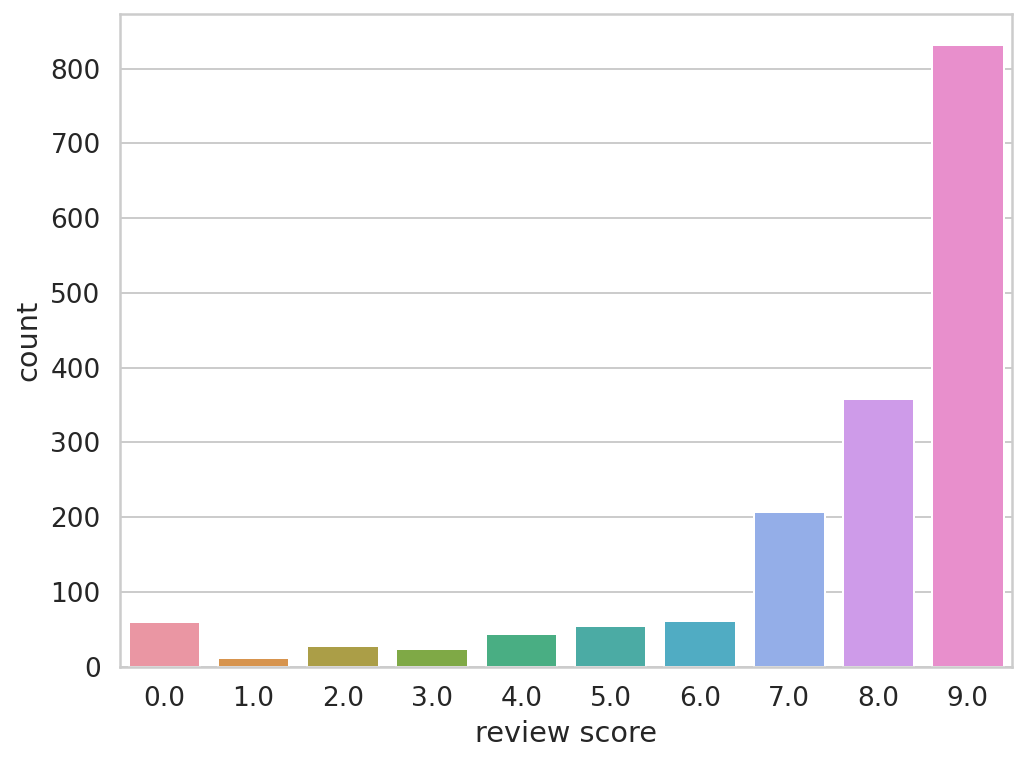

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.sentiment)
plt.xlabel('review score');

In [ ]:
# def sentiment2label(sentiment):
#     if sentiment == "positive":
#         return 1
#     else :
#         return 0

# df['sentiment'] = df['sentiment'].apply(sentiment2label)

In [ ]:
df['sentiment'].value_counts()


9.0    831
8.0    358
7.0    207
6.0     61
0.0     59
5.0     54
4.0     43
2.0     28
3.0     23
1.0     11
Name: sentiment, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 1582 to 1126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     1675 non-null   object 
 1   sentiment  1675 non-null   float64
dtypes: float64(1), object(1)
memory usage: 119.3+ KB


In [ ]:
class_names = [str(i) for i in range(10)]


In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

In [ ]:
print('input_ids : ',encodings['input_ids'])


input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [ ]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])


['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [ ]:
type(encodings['attention_mask'])


torch.Tensor

In [ ]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")


In [ ]:

attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
encodings['input_ids']


tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

In [ ]:
token_lens = []

for txt in df['review']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


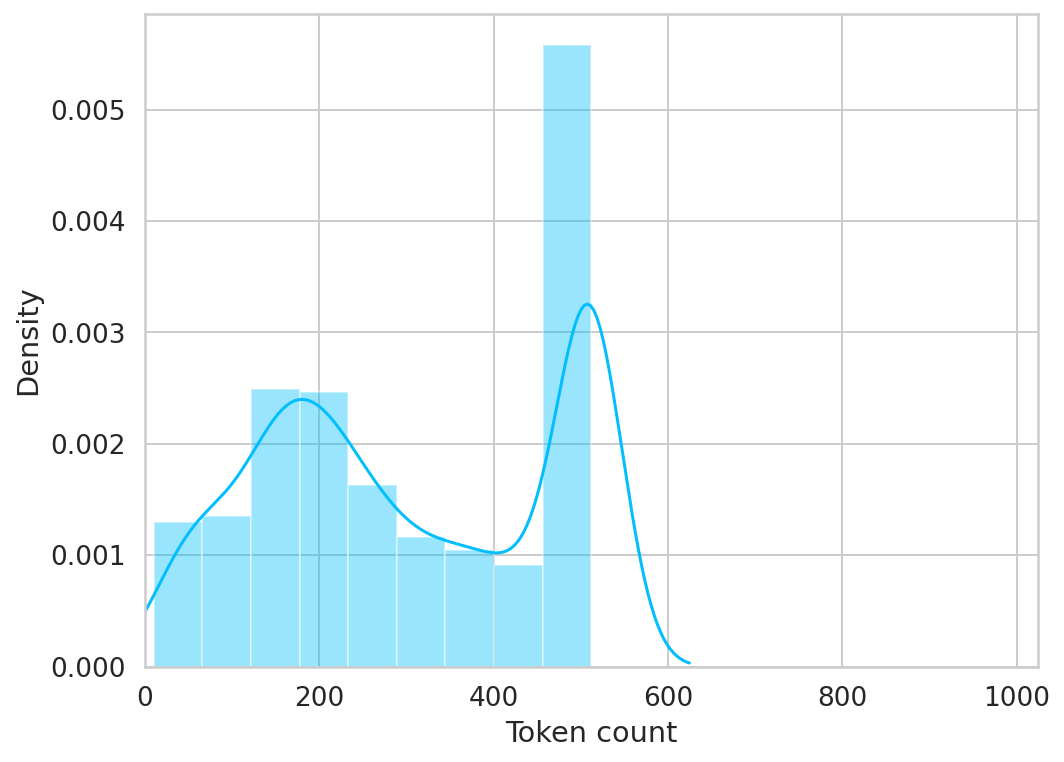

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 512


In [ ]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.float)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1507, 2), (84, 2), (84, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(dtype = np.float64),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from transformers import XLNetForSequenceClassification
from transformers import XLNetConfig


config = XLNetConfig.from_pretrained("xlnet-base-cased", num_labels=1)
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", config=config)


# model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 1)
model = model.to(device)

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
EPOCHS = 40

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
# # (iter(train_data_loader))

# *_  , last = iter(train_data_loader) # for a better understanding check PEP 448
# data = slast
# data.keys()


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(4,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
input_ids[0]

tensor([[ 1710, 16170, 27173,   468,    40, 13333,   984,    23, 10857,  7977,
          3405, 11624,  8116,  1238, 20580,    23,    77,   318,    34,  8116,
          1238, 20580,    27,    24,  9290,   777,    20,  2396,  9769,    21,
          9621,     9,    32,  4487, 18850,    23,   199,    87,   412, 20796,
         20847, 10857,  7977,  3405,    21, 12741,  3836,    93,  8171,  6899,
            46,    61,  2147, 15061,    22,  2396,    18,    17, 10997,    46,
          1406,   326,    61,    27, 20796,    26,    23,  1637,    21, 12741,
            26,    23, 11139,  9614,   507,    37,    18, 19906,   111,    17,
            23,  1797,  4693,  1209,  1275,  1067, 13279,     9,    69,    27,
            18,  3824,    20,    24, 13578,   297,    28,  3434,    61, 15429,
            31, 20847,    26,    23,   356,    22,   309,    45,  6662,   202,
            21,    18,    87,   412,    41,   207,  2983,    38,    18,   297,
             9, 15961,   101,    51,    62, 10612,  

In [ ]:
outputs = model(input_ids.reshape(4,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

(tensor(57.3188, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor([[-0.3546],
         [-0.3154],
         [-0.1971],
         [-0.5348]], device='cuda:0', grad_fn=<AddmmBackward>))

In [ ]:
type(outputs[0])

torch.Tensor

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
    l = len(iter(data_loader))
  
    for d in data_loader:
        if counter < l-1:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            # preds = preds.cpu().detach().numpy()
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
# TRAINING CELL

# %%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis/models/xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/40
----------
Train loss 4.391241770435838 Train accuracy 0.0339095744680851
Val loss 5.402132911341531 Val accuracy 0.05952380952380952

Epoch 2/40
----------
Train loss 2.6004863909911364 Train accuracy 0.0339095744680851
Val loss 3.5202430188655853 Val accuracy 0.05952380952380952

Epoch 3/40
----------
Train loss 2.0128259107153466 Train accuracy 0.0339095744680851
Val loss 3.1560936385676976 Val accuracy 0.05952380952380952

Epoch 4/40
----------
Train loss 1.107643831605488 Train accuracy 0.0339095744680851
Val loss 2.0419462834085738 Val accuracy 0.05952380952380952

Epoch 5/40
----------
Train loss 1.1011195146680581 Train accuracy 0.0339095744680851
Val loss 1.1310104140568347 Val accuracy 0.05952380952380952

Epoch 6/40
----------
Train loss 0.7402483995253359 Train accuracy 0.0339095744680851
Val loss 4.070454057483446 Val accuracy 0.05952380952380952

Epoch 7/40
----------
Train loss 0.5705482865221788 Train accuracy 0.0339095744680851
Val loss 2.936328219161147 Val

In [53]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis/models/xlnet_model.bin'))


<All keys matched successfully>

In [54]:
model = model.to(device)


In [55]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.03571428571428571
Test Loss : 5.001906321871848


In [56]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [57]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

           0       0.04      1.00      0.07         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        39

    accuracy                           0.04        84
   macro avg       0.00      0.10      0.01        84
weighted avg       0.00      0.04      0.00        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score:", probs[1])
    print("Negative score:", probs[0])
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [60]:
text = "Movie is the worst one I have ever seen!! The story has no meaning at all"
predict_sentiment(text)

IndexError: ignored

In [61]:
text = "This is the best movie I have ever seen!! The story is such a motivation"
predict_sentiment(text)

IndexError: ignored

In [ ]:
text = "the acting was the best from my favorite actor. The story was bizarre though. The acting of other actors was  so less inspiring"
predict_sentiment(text)